In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import pymeshlab as pml
import time

### Calibration

In [86]:
CHESSBOARD_CORNER_NUM_X = 8
CHESSBOARD_CORNER_NUM_Y = 6

In [87]:
# Initialize both webcams
cap1 = cv2.VideoCapture(0)  # Default webcam
cap2 = cv2.VideoCapture(1)  # Second webcam

# Check if cameras opened successfully
if not cap1.isOpened() or not cap2.isOpened():
    print("Error: Could not open one or both cameras")
    exit()

index = 1
while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if ret1 and ret2:
        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        # Save the images when 's' is pressed
        key = cv2.waitKey(1)
        if key & 0xFF == ord('s'):
            cv2.imwrite(f'calibration/left/{index}.jpg', frame1)
            cv2.imwrite(f'calibration/right/{index}.jpg', frame2)
            print(f"Saved image pair {index}")
            index += 1
        # Break on 'q' key press
        if key & 0xFF == ord('q'):
            break
    else:
        print("Failed to capture image pair")

# Release the cameras
cap1.release()
cap2.release()
cv2.destroyAllWindows()

Saved image pair 1
Saved image pair 2
Saved image pair 3
Saved image pair 4
Saved image pair 5
Saved image pair 6


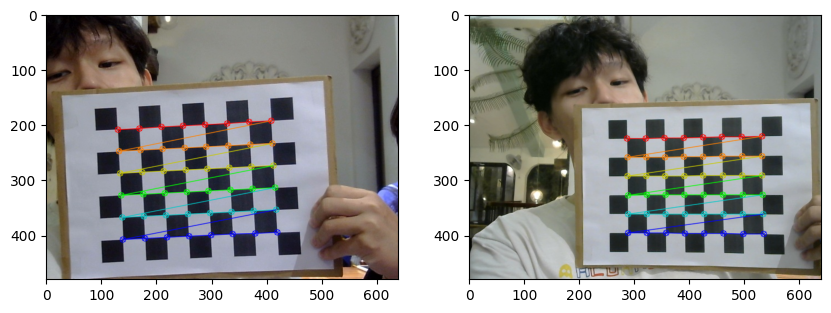

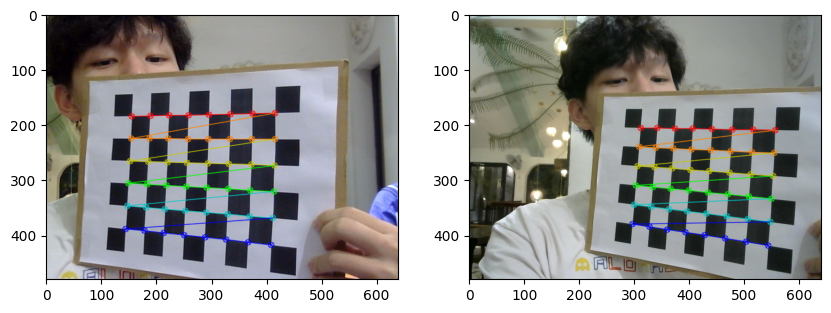

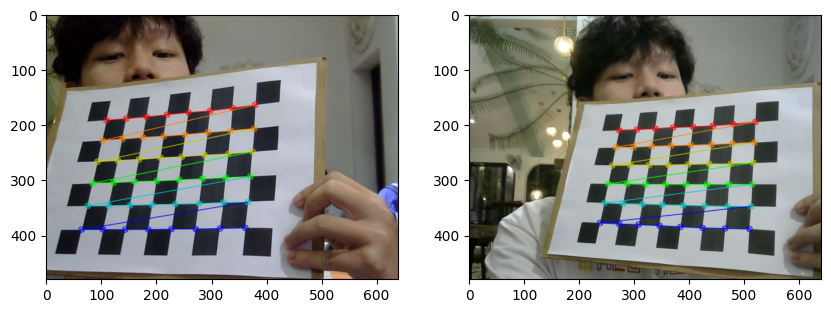

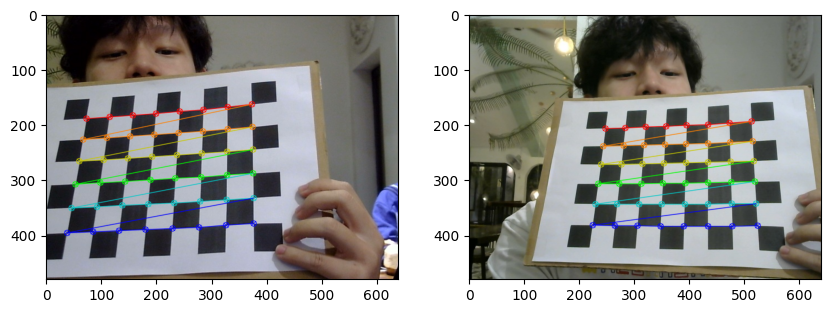

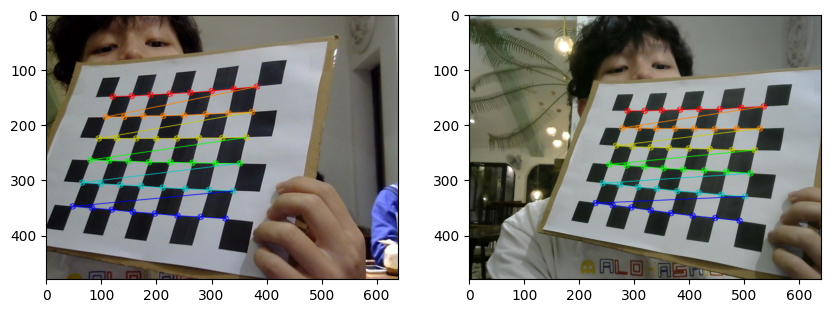

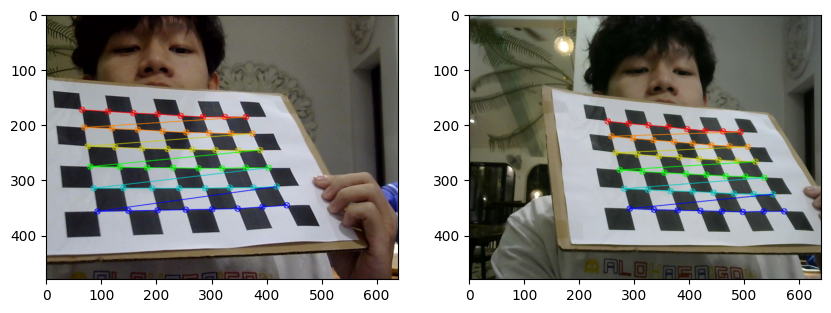

In [88]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((CHESSBOARD_CORNER_NUM_X*CHESSBOARD_CORNER_NUM_Y,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X*40:40,0:CHESSBOARD_CORNER_NUM_Y*40:40].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

imagesLeft = glob.glob('./calibration/left/*.jpg')
imagesRight = glob.glob('./calibration/right/*.jpg')

for imgLeft, imgRight in zip(imagesLeft, imagesRight):
    imgL = cv2.imread(imgLeft)
    imgR = cv2.imread(imgRight)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv2.findChessboardCorners(grayL, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    retR, cornersR = cv2.findChessboardCorners(grayR, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    # If found, add object points, image points (after refining them)
    if retL and retR == True:
        objpoints.append(objp)

        cornersL = cv2.cornerSubPix(grayL,cornersL, (11,11), (-1,-1), criteria)
        imgpointsL.append(cornersL)
        cornersR = cv2.cornerSubPix(grayR,cornersR, (11,11), (-1,-1), criteria)
        imgpointsR.append(cornersR)

        # Draw and display the corners
        cv2.drawChessboardCorners(imgL, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), cornersL, retL)
        cv2.drawChessboardCorners(imgR, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), cornersR, retR)
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(imgL[:,:,::-1])
        plt.subplot(1,2,2)
        plt.imshow(imgR[:,:,::-1])

In [89]:
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, grayL.shape[::-1], None, None)
print(f"Left camera\nMatrix: \n{mtxL}\nDistortion coefficients : \n{distL}")
heightL, widthL, channelsL = imgL.shape
newCameraMatrixL, roiL = cv2.getOptimalNewCameraMatrix(mtxL, distL, (widthL, heightL), 1, (widthL, heightL))
print()

retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, grayR.shape[::-1], None, None)
print(f"Right camera\nMatrix is \n{mtxR}\nDistortion coefficients : \n{distR}")
heightR, widthR, channelsR = imgR.shape
newCameraMatrixR, roiR = cv2.getOptimalNewCameraMatrix(mtxR, distR, (widthR, heightR), 1, (widthR, heightR))

Left camera
Matrix: 
[[1.01323516e+03 0.00000000e+00 2.94355741e+02]
 [0.00000000e+00 1.04595919e+03 1.01775569e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients : 
[[ 0.24771248 -0.87015953 -0.07123968 -0.01028125  3.15876995]]

Right camera
Matrix is 
[[876.81929887   0.         295.1403875 ]
 [  0.         896.05429159 128.0266442 ]
 [  0.           0.           1.        ]]
Distortion coefficients : 
[[-3.62445945e-02  6.28735993e-01 -4.36433813e-02  3.91363125e-04
  -1.39320257e+00]]


In [90]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
criteria_stereo = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)
retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, R, T, essentialMatrix, fundamentalMatrix = cv2.stereoCalibrate(objpoints, imgpointsL, imgpointsR, newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], criteria_stereo, flags)

In [91]:
rectifyScale = 1
rectL, rectR, projMatrixL, projMatrixR, Q, roiL, roiR = cv2.stereoRectify(
    newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], R, T, rectifyScale, (0, 0))

stereoMapL = cv2.initUndistortRectifyMap(newCameraMatrixL, distL, rectL, projMatrixL, grayL.shape[::-1], cv2.CV_16SC2)
stereoMapR = cv2.initUndistortRectifyMap(newCameraMatrixR, distR, rectR, projMatrixR, grayR.shape[::-1], cv2.CV_16SC2)

In [92]:
cv_file = cv2.FileStorage('stereoMap.xml', cv2.FILE_STORAGE_WRITE)
cv_file.write("stereoMapL_x", stereoMapL[0])
cv_file.write("stereoMapL_y", stereoMapL[1])
cv_file.write("stereoMapR_x", stereoMapR[0])
cv_file.write("stereoMapR_y", stereoMapR[1])
cv_file.release()

### Depth Map

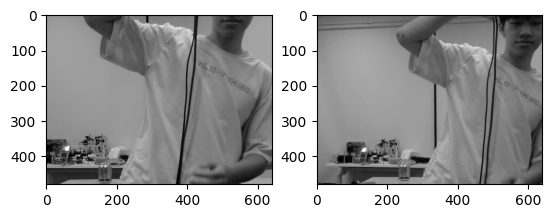

In [9]:
imgL = cv2.imread('frames/left/frame_left.jpg', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('frames/right/frame_right.jpg', cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(imgL, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgR, cmap='gray')

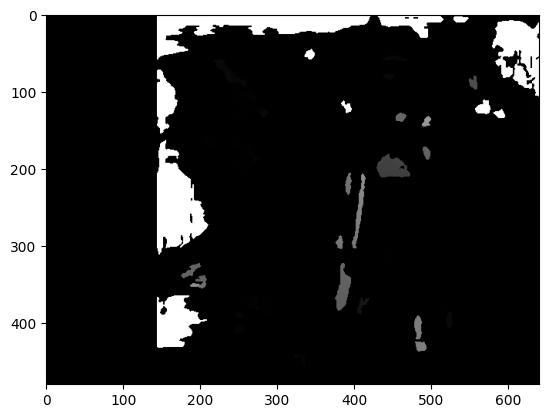

In [10]:
NUM_DISPARITIES = 9
BLOCK_SIZE = 15
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*NUM_DISPARITIES,
    blockSize=BLOCK_SIZE,
    P1=8 * 3 * BLOCK_SIZE ** 2,
    P2=32 * 3 * BLOCK_SIZE ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)
disparity = stereo.compute(imgL,imgR)
cv2.imwrite('depth.png',disparity)
plt.imshow(disparity, cmap='gray')

In [ ]:
with open("camera_params.json", 'r') as f:
    params = json.load(f)

color_intrinsics = params["color_intrinsics"]
fx_color = color_intrinsics["fx"]
fy_color = color_intrinsics["fy"]
ppx_color = color_intrinsics["ppx"]
ppy_color = color_intrinsics["ppy"]

depth_intrinsics = params["depth_intrinsics"]
fx_depth = depth_intrinsics["fx"]
fy_depth = depth_intrinsics["fy"]
ppx_depth = depth_intrinsics["ppx"]
ppy_depth = depth_intrinsics["ppy"]

R = np.array(params["extrinsics"]["rotation"]).reshape(3, 3)
t = np.array(params["extrinsics"]["translation"]).reshape(3, 1)

In [ ]:
depth_scale = 1000.0
color_img = cv2.imread('frames/left/1.png')
color_img_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
depth_img = cv2.imread("depth.png", cv2.IMREAD_UNCHANGED)
depth = depth_img.astype(np.float32) / depth_scale

h, w = depth.shape
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
X_depth = (x_coords - ppx_depth) * depth / fx_depth
Y_depth = (y_coords - ppy_depth) * depth / fy_depth
Z_depth = depth

In [ ]:
points_depth = np.stack((X_depth, Y_depth, Z_depth), axis=-1)
points_depth_flat = points_depth.reshape(-1, 3).T
points_color_flat = (R @ points_depth_flat) + t
points_color = points_color_flat.T.reshape(h, w, 3)

points_color_flat = points_color.reshape(-1, 3)
valid_mask = points_color_flat[:, 2] > 0

points_color_valid = points_color_flat[valid_mask]

Xc = points_color_valid[:, 0]
Yc = points_color_valid[:, 1]
Zc = points_color_valid[:, 2]
u = np.round(fx_color * (Xc / Zc) + ppx_color).astype(np.int32)
v = np.round(fy_color * (Yc / Zc) + ppy_color).astype(np.int32)

valid_proj = (u >= 0) & (u < color_img_rgb.shape[1]) & (v >= 0) & (v < color_img_rgb.shape[0])
points_color_valid = points_color_valid[valid_proj]
u = u[valid_proj]
v = v[valid_proj]

colors = color_img_rgb[v, u, :]
colors_normalized = colors / 255.0

In [ ]:
with open("output.ply", 'wb') as f:
    # Write header
    f.write(b'ply\n')
    f.write(b'format binary_little_endian 1.0\n')
    f.write(f'element vertex {points_color_valid.shape[0]}\n'.encode())
    f.write(b'property float x\n')
    f.write(b'property float y\n')
    f.write(b'property float z\n')
    f.write(b'property uchar red\n')
    f.write(b'property uchar green\n')
    f.write(b'property uchar blue\n')
    f.write(b'end_header\n')

    # Convert data to structured array
    vertex_dtype = np.dtype([
        ('x', np.float32),
        ('y', np.float32),
        ('z', np.float32),
        ('red', np.uint8),
        ('green', np.uint8),
        ('blue', np.uint8)
    ])

    # Create structured array
    vertices = np.empty(points_color_valid.shape[0], dtype=vertex_dtype)
    vertices['x'] = points_color_valid[:, 0]
    vertices['y'] = points_color_valid[:, 1]
    vertices['z'] = points_color_valid[:, 2]
    vertices['red'] = colors[:, 2]
    vertices['green'] = colors[:, 1]
    vertices['blue'] = colors[:, 0]

    # Write data
    vertices.tofile(f)

In [ ]:
ms = pml.MeshSet()
ms.load_new_mesh("output.ply")
ms.show_polyscope()

### Distance Detection

In [93]:
# Initialize both webcams
cap1 = cv2.VideoCapture(0)  # Default webcam
cap2 = cv2.VideoCapture(1)  # Second webcam

# Check if cameras opened successfully
if not cap1.isOpened() or not cap2.isOpened():
    print("Error: Could not open one or both cameras")
    exit()

index = 1
while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if ret1 and ret2:
        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        # Save the images when 's' is pressed
        key = cv2.waitKey(1)
        if key & 0xFF == ord('s'):
            cv2.imwrite(f'frames/left/{index}.jpg', frame1)
            cv2.imwrite(f'frames/right/{index}.jpg', frame2)
            print(f"Saved image pair {index}")
            index += 1
        # Break on 'q' key press
        if key & 0xFF == ord('q'):
            break
    else:
        print("Failed to capture image pair")

# Release the cameras
cap1.release()
cap2.release()
cv2.destroyAllWindows()

Saved image pair 1
Saved image pair 2
Saved image pair 3
Saved image pair 4
Saved image pair 5
Saved image pair 6
Saved image pair 7
Saved image pair 8
Saved image pair 9
Saved image pair 10
Saved image pair 11
Saved image pair 12
Saved image pair 13
Saved image pair 14
Saved image pair 15


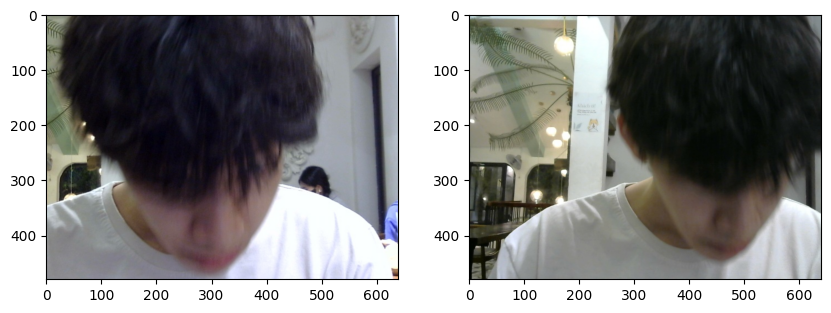

In [111]:
imgL = cv2.imread('frames/left/4.jpg')
imgR = cv2.imread('frames/right/4.jpg')

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(imgL[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(imgR[:,:,::-1])
plt.show()

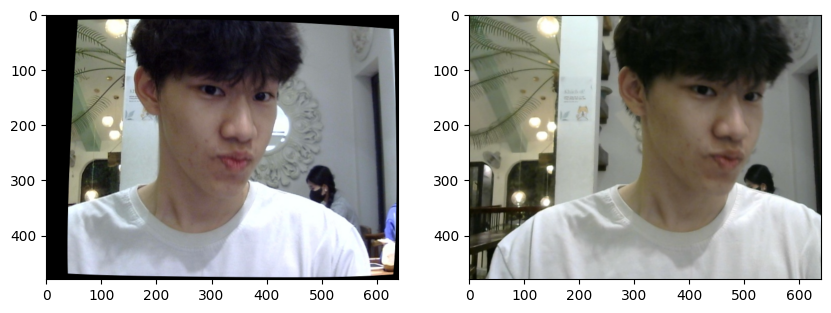

In [97]:
cv_file = cv2.FileStorage("stereoMap.xml", cv2.FILE_STORAGE_READ)
Left_Stereo_Map_x = cv_file.getNode("stereoMapL_x").mat()
Left_Stereo_Map_y = cv_file.getNode("stereoMapL_y").mat()
Right_Stereo_Map_x = cv_file.getNode("stereoMapR_x").mat()
Right_Stereo_Map_y = cv_file.getNode("stereoMapR_y").mat()
cv_file.release()

Left_nice= cv2.remap(imgL, Left_Stereo_Map_x, Left_Stereo_Map_y, cv2.INTER_LINEAR)
Right_nice= cv2.remap(imgR, Right_Stereo_Map_x, Right_Stereo_Map_y, cv2.INTER_LINEAR)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(Left_nice[:,:,::-1])
plt.subplot(1, 2, 2)
plt.imshow(Right_nice[:,:,::-1])
plt.show()

In [108]:
imgL_gray = cv2.cvtColor(Left_nice,cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(Right_nice,cv2.COLOR_BGR2GRAY)

def nothing(x):
    pass

cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
cv2.resizeWindow('disp',600,600)

cv2.createTrackbar('numDisparities','disp',1,17,nothing)
cv2.createTrackbar('blockSize','disp',5,50,nothing)
cv2.createTrackbar('preFilterType','disp',1,1,nothing)
cv2.createTrackbar('preFilterSize','disp',2,25,nothing)
cv2.createTrackbar('preFilterCap','disp',5,62,nothing)
cv2.createTrackbar('textureThreshold','disp',10,100,nothing)
cv2.createTrackbar('uniquenessRatio','disp',15,100,nothing)
cv2.createTrackbar('speckleRange','disp',0,100,nothing)
cv2.createTrackbar('speckleWindowSize','disp',3,25,nothing)
cv2.createTrackbar('disp12MaxDiff','disp',5,25,nothing)
cv2.createTrackbar('minDisparity','disp',5,25,nothing)

stereo = cv2.StereoBM_create()
while True:
    numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
    blockSize = cv2.getTrackbarPos('blockSize','disp')*2 + 5
    preFilterType = cv2.getTrackbarPos('preFilterType','disp')
    preFilterSize = cv2.getTrackbarPos('preFilterSize','disp')*2 + 5
    preFilterCap = cv2.getTrackbarPos('preFilterCap','disp')
    textureThreshold = cv2.getTrackbarPos('textureThreshold','disp')
    uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
    speckleRange = cv2.getTrackbarPos('speckleRange','disp')
    speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')*2
    disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff','disp')
    minDisparity = cv2.getTrackbarPos('minDisparity','disp')

    stereo.setNumDisparities(numDisparities)
    stereo.setBlockSize(blockSize)
    stereo.setPreFilterType(preFilterType)
    stereo.setPreFilterSize(preFilterSize)
    stereo.setPreFilterCap(preFilterCap)
    stereo.setTextureThreshold(textureThreshold)
    stereo.setUniquenessRatio(uniquenessRatio)
    stereo.setSpeckleRange(speckleRange)
    stereo.setSpeckleWindowSize(speckleWindowSize)
    stereo.setDisp12MaxDiff(disp12MaxDiff)
    stereo.setMinDisparity(minDisparity)

    disparity = stereo.compute(imgL_gray,imgR_gray)
    disparity = disparity.astype(np.float32)
    disparity = (disparity / 16.0 - minDisparity) /numDisparities
    cv2.imshow("disp", disparity)

    if cv2.waitKey(1) == 27:
        break

plt.imshow(disparity, 'gray')
plt.title('Disparity Map')
plt.colorbar()
plt.show()
# Camera parameters from calibration
focal_length = 720  # in pixels
baseline = 0.075     # in meters

# Avoid division by zero
disparity[disparity <= 0] = 0.1

# Compute depth map
depth_map = (focal_length * baseline) / disparity

# Display depth map
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title('Depth Map')
plt.show()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2564: error: (-27:Null pointer) NULL window: 'disp' in function 'cvGetTrackbarPos'
